# Import all library 

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import random
import unicodedata
import re
import numpy as np
import os
import io
import time

# Create the class for doing preprocessing and separation of dataset

In [2]:
class NMTDataset:
    def __init__(self, problem_type='it-en'):
        self.problem_type = 'it-en'
        self.inp_lang_tokenizer = None
        self.targ_lang_tokenizer = None
        
    
    def shuffle_all(self,path_input,path_output):
        lines = open(path_input, encoding='UTF-8').readlines()
        random.shuffle(lines)
        open(path_output, 'w' , encoding="utf-8").writelines(lines)


    def unicode_to_ascii(self, s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


    def preprocess_sentence(self, w):
        w = self.unicode_to_ascii(w.lower().strip())

        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        

        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

        w = w.strip()

        # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w

    def create_dataset(self, path, num_examples):
        # path : path to ita-eng.txt file
        
        #do not comment this function if we you want to mix data
        #self.shuffle_all('it.txt','first_shuffle_data.txt')
        lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

        word_pairs = [[self.preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

        return zip(*word_pairs)


    def tokenize(self, lang):
        # lang = list of sentences in a language

        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
        lang_tokenizer.fit_on_texts(lang)

        ## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
        ## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
        tensor = lang_tokenizer.texts_to_sequences(lang) 

        ## tf.keras.preprocessing.sequence.pad_sequences takes argument a list of integer id sequences 
        ## and pads the sequences to match the longest sequences in the given input
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, lang_tokenizer

    def load_dataset(self, path, num_examples=None):
        # creating cleaned input, output pairs
        targ_lang, inp_lang = self.create_dataset(path, num_examples)
        
        train_targ, test_targ, train_inp, test_inp = train_test_split(targ_lang, inp_lang, test_size=0.2, shuffle = True, random_state = 8)

        input_tensor, inp_lang_tokenizer = self.tokenize(train_inp)
        target_tensor, targ_lang_tokenizer = self.tokenize(train_targ)

        return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer,test_targ,test_inp

    def call(self, num_examples, BUFFER_SIZE, BATCH_SIZE):
        file_path = 'dataset/first_shuffle_data.txt'
        input_tensor, target_tensor, self.inp_lang_tokenizer, self.targ_lang_tokenizer,test_targ,test_inp = self.load_dataset(file_path, num_examples)
        
        input_tensor_test, inp_lang_tokenizer = self.tokenize(test_inp)
        target_tensor_test, targ_lang_tokenizer = self.tokenize(test_targ)

        test_dataset = [test_targ, test_inp]
        
        #separate training with validation
        train_x, X_val, train_y, y_val = train_test_split(input_tensor, target_tensor, test_size=0.25) # 0.25 x 0.8 = 0.2

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
        train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
        
        test_data = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test))
        test_data = test_data.batch(BATCH_SIZE, drop_remainder=True)

        return train_dataset, val_dataset, test_dataset, test_data, self.inp_lang_tokenizer, self.targ_lang_tokenizer

## Test the class with some function

#### Let's print some functions of the class

In [3]:
dataset_creator = NMTDataset('it-en')

#### preprocess_sentence

In [4]:
tot= dataset_creator.preprocess_sentence("prova di preprocessing .")
print(tot)

<start> prova di preprocessing . <end>


#### create_dataset

In [5]:
frase_input,frase_output=dataset_creator.create_dataset('dataset/first_shuffle_data.txt',50)
print(frase_input[0])
print(frase_output[0])

<start> tom looks very pleased . <end>
<start> tom sembra molto compiaciuto . <end>


#### load_dataset

In [6]:
input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer,test_targ,test_inp =dataset_creator.load_dataset('dataset/first_shuffle_data.txt',3)
print(input_tensor)
print(target_tensor)
print(inp_lang_tokenizer.word_index)
print(targ_lang_tokenizer.word_index)
print("test_targ:",test_targ)
print("test_inp:",test_inp)

[[ 2  3  6  7  8  9  4  5]
 [ 2 10  3 11 12  4  5  0]]
[[ 2  5  6  7  8  9  3  4]
 [ 2 10 11 12 13  3  4  0]]
{'<OOV>': 1, '<start>': 2, 'sembra': 3, '.': 4, '<end>': 5, 'che': 6, 'piaccia': 7, 'a': 8, 'tutti': 9, 'tom': 10, 'molto': 11, 'compiaciuto': 12}
{'<OOV>': 1, '<start>': 2, '.': 3, '<end>': 4, 'everybody': 5, 'seems': 6, 'to': 7, 'like': 8, 'it': 9, 'tom': 10, 'looks': 11, 'very': 12, 'pleased': 13}
test_targ: ['<start> i don t know anything about your job . <end>']
test_inp: ['<start> non so niente del vostro lavoro . <end>']


In [7]:
lines = io.open('dataset/first_shuffle_data.txt', encoding='UTF-8').read().strip().split('\n')
num_examples = len(lines) 
print("numero di line: ", num_examples)

numero di line:  352894


# Start creating my model

#### setting first parameters

In [8]:
BATCH_SIZE = 64

num_examples = 30000

BUFFER_SIZE = 30000 


dataset_creator = NMTDataset('it-en')
train_dataset, val_dataset, test_dataset, test_data, inp_lang, targ_lang = dataset_creator.call(num_examples, BUFFER_SIZE, BATCH_SIZE)

In [9]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 79]), TensorShape([64, 76]))

In [10]:
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
max_length_input = example_input_batch.shape[1]
max_length_output = example_target_batch.shape[1]

print('max_length_input',max_length_input)
print('max_length_output',max_length_output)

embedding_dim = 512 
units = 1024 
steps_per_epoch = int((((num_examples*80)/100)*75)/100//BATCH_SIZE)
print("steps_per_epoch:",steps_per_epoch)

max_length_input 79
max_length_output 76
steps_per_epoch: 281


In [11]:
print("max_length_english, max_length_italian, vocab_size_english, vocab_size_italian")
max_length_input, max_length_output, vocab_inp_size, vocab_tar_size

max_length_english, max_length_italian, vocab_size_english, vocab_size_italian


(79, 76, 9721, 5965)

## Encoder

In [12]:
#####

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
                                    #Embedding (input_dim,output_dim)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    ##-------- LSTM layer in Encoder ------- ##
    self.lstm_layer = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True)


  def call(self, x, hidden):
    x = self.embedding(x)
    #h=hidden state
    #c=cell state
    output, h, c = self.lstm_layer(x, initial_state = hidden)
    return output, h, c

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))]

### Test Encoder Stack

In [13]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder h vecotr shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (64, 79, 1024)
Encoder h vecotr shape: (batch size, units) (64, 1024)
Encoder c vector shape: (batch size, units) (64, 1024)


## Decoder

In [14]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_type='luong'):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.attention_type = attention_type

    # Embedding Layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    #Final Dense layer on which softmax will be applied
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Define the fundamental cell for decoder recurrent structure
    self.decoder_rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)

    # Sampler
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()

    # Define the decoder with respect to fundamental rnn cell
    self.decoder = tfa.seq2seq.BasicDecoder(self.decoder_rnn_cell, sampler=self.sampler, output_layer=self.fc)

  def build_initial_state(self, batch_sz, encoder_state, Dtype):
    decoder_initial_state = self.decoder_rnn_cell
    decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
    return decoder_initial_state


  def call(self, inputs, initial_state):
    x = self.embedding(inputs)
    outputs, _, _ = self.decoder(x, initial_state=initial_state, sequence_length=self.batch_sz*[max_length_output-1])
    return outputs

### Test Decoder Stack

In [15]:

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_x = tf.random.uniform((BATCH_SIZE, max_length_output))
#initial_state = decoder.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)

sample_decoder_outputs = decoder(sample_x,  [sample_h, sample_c])

print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)

Decoder Outputs Shape:  (64, 75, 5965)


### Define metods for Loss function

In [16]:
optimizer = tf.keras.optimizers.Adam()


def loss_function(real, pred):
  # real shape = (BATCH_SIZE, max_length_output)
  # pred shape = (BATCH_SIZE, max_length_output, tar_vocab_size )
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  mask = tf.logical_not(tf.math.equal(real,0))   #output 0 for y=0 else output 1
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = mask* loss 
  loss = tf.reduce_mean(loss)
  return loss

## Print Architecture of Model

#### Encoder

In [17]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  4977152   
                                                                 
 lstm (LSTM)                 multiple                  6295552   
                                                                 
Total params: 11,272,704
Trainable params: 11,272,704
Non-trainable params: 0
_________________________________________________________________


#### Decoder

In [18]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  3054080   
                                                                 
 dense (Dense)               multiple                  6114125   
                                                                 
 lstm_cell_1 (LSTMCell)      multiple                  6295552   
                                                                 
 basic_decoder (BasicDecoder  multiple                 12409677  
 )                                                               
                                                                 
Total params: 15,463,757
Trainable params: 15,463,757
Non-trainable params: 0
_________________________________________________________________


## Checkpoint Settings 

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Train Step

In [20]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)


    dec_input = targ[ : , :-1 ] # Ignore <end> token
    real = targ[ : , 1: ]         # ignore <start> token

    # Create AttentionWrapperState as initial_state for decoder
    #decoder_initial_state = decoder.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
    pred = decoder(dec_input, [enc_h, enc_c])
    logits = pred.rnn_output
    loss = loss_function(real, logits)

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return loss

In [21]:
#steps_per_epoch = num_examples//BATCH_SIZE

print("ogni epoca duerà:", num_examples//BATCH_SIZE)

ogni epoca duerà: 468


## Function for loss on training and validation

In [22]:
def loss(inp, targ, enc_hidden):
  loss = 0
  enc_output, enc_h, enc_c = encoder(inp, enc_hidden)

  dec_input = targ[ : , :-1 ] # Ignore <end> token
  real = targ[ : , 1: ]         # ignore <start> token

  # Create AttentionWrapperState as initial_state for decoder
  #decoder_initial_state = decoder.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
  pred = decoder(dec_input, [enc_h, enc_c])
  logits = pred.rnn_output
  loss = loss_function(real, logits)
  return loss.numpy()

In [23]:
def validation_score(enc_hidden,dataset):
    total_loss=0
    conta=0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss_val = loss(inp, targ, enc_hidden)
        total_loss += batch_loss_val
        conta +=1
    total_loss=total_loss/conta
    return total_loss

In [24]:
print(val_dataset.take(steps_per_epoch))

<TakeDataset shapes: ((64, 79), (64, 76)), types: (tf.int32, tf.int32)>


#### Graph settings

In [25]:
def make_graph(loss_tr_values,loss_vl_values):
  epochs = range(1, len(loss_vl_values)+1)
  plt.plot(epochs, loss_tr_values, 'b', label='Training Loss', c='r')
  plt.plot(epochs, loss_vl_values, 'b', label='Validation Loss', c='b')
  plt.title('Training and validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# Training and Validation

le iterazioni totali saranno: 281 per epoca, in totale: 2810
Epoch 1/10 Batch 0/281 Loss 0.9182
Epoch 1/10 Batch 100/281 Loss 0.4033
Epoch 1/10 Batch 200/281 Loss 0.4022
Epoch 1/10 Loss 0.4725
Time taken for 1 epoch 152.10245418548584 sec

Training total score: 0.39127616536574855
Validation total score: 0.4049117238290848
Total duration: 4.681412390867869 min

Epoch 2/10 Batch 0/281 Loss 0.3635
Epoch 2/10 Batch 100/281 Loss 0.3583
Epoch 2/10 Batch 200/281 Loss 0.3926
Epoch 2/10 Loss 0.3764
Time taken for 1 epoch 146.9659924507141 sec

Training total score: 0.34613755345344543
Validation total score: 0.3732315795395964
Total duration: 4.515312548478445 min

Epoch 3/10 Batch 0/281 Loss 0.3142
Epoch 3/10 Batch 100/281 Loss 0.3093
Epoch 3/10 Batch 200/281 Loss 0.3141
Epoch 3/10 Loss 0.3437
Time taken for 1 epoch 145.72936511039734 sec

Training total score: 0.3187138795640545
Validation total score: 0.36052032920622057
Total duration: 4.5296964327494305 min

Epoch 4/10 Batch 0/281 Loss 0.

<ipython-input-25-e0d72c9850d0>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_tr_values, 'b', label='Training Loss', c='r')
<ipython-input-25-e0d72c9850d0>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_vl_values, 'b', label='Validation Loss', c='b')


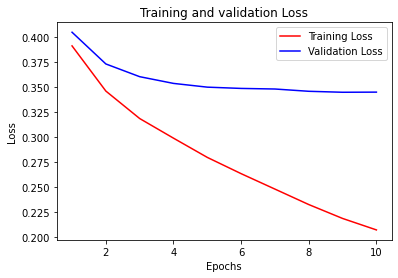

In [26]:
EPOCHS = 10
print( "le iterazioni totali saranno:", steps_per_epoch,"per epoca, in totale:",(steps_per_epoch*EPOCHS))
loss_tr_values = []
loss_vl_values = []

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    conta=0
    
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        conta+= 1
        if batch % 100 == 0:
          print('Epoch {}/{} Batch {}/{} Loss {:.4f}'.format(epoch + 1,EPOCHS,
                                                       batch,  steps_per_epoch,
                                                       batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    #if (epoch + 1) % 2 == 0:
    #    checkpoint.save(file_prefix = checkpoint_prefix)
        
    print('Epoch {}/{} Loss {:.4f}'.format(epoch + 1, EPOCHS,
                                      total_loss/conta))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    #Compute LOSS training
    ls=validation_score(enc_hidden,train_dataset)
    loss_tr_values.append(ls)
    print('Training total score:',ls)
    
    #Compute LOSS validation
    vs=validation_score(enc_hidden,val_dataset)
    loss_vl_values.append(vs)
    print('Validation total score:',vs)

    
    print('Total duration: {} min\n'.format((time.time() - start)/60.0))

make_graph(loss_tr_values,loss_vl_values)


<ipython-input-25-e0d72c9850d0>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_tr_values, 'b', label='Training Loss', c='r')
<ipython-input-25-e0d72c9850d0>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_vl_values, 'b', label='Validation Loss', c='b')


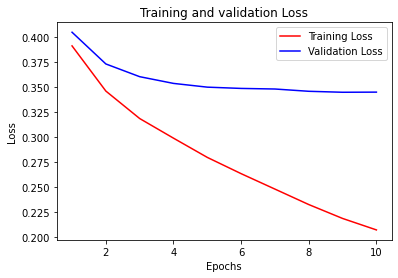

In [27]:
make_graph(loss_tr_values,loss_vl_values)

### Save the model or restore previous

In [28]:
#save model on checkpoint
checkpoint.save(file_prefix = checkpoint_prefix)

# restoring the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

'./training_checkpoints\\ckpt-1'

# Test

In [29]:
def evaluate_sentence(sentence):
  sentence = dataset_creator.preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)
  inference_batch_size = inputs.shape[0]
  result = ''

  enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
  enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

  dec_h = enc_h
  dec_c = enc_c

  start_tokens = tf.fill([inference_batch_size], targ_lang.word_index['<start>'])
  end_token = targ_lang.word_index['<end>']

  greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

  # Instantiate BasicDecoder object
  decoder_instance = tfa.seq2seq.BasicDecoder(cell=decoder.decoder_rnn_cell, sampler=greedy_sampler, output_layer=decoder.fc)

  ### Since the BasicDecoder wraps around Decoder's rnn cell only, you have to ensure that the inputs to BasicDecoder 
  ### decoding step is output of embedding layer. tfa.seq2seq.GreedyEmbeddingSampler() takes care of this. 
  ### You only need to get the weights of embedding layer, which can be done by decoder.embedding.variables[0] and pass this callabble to BasicDecoder's call() function

  decoder_embedding_matrix = decoder.embedding.variables[0]

  outputs, _, _ = decoder_instance(decoder_embedding_matrix, start_tokens = start_tokens, end_token= end_token, initial_state= [enc_h, enc_c])
  return outputs.sample_id.numpy()

def translate(sentence):
  result = evaluate_sentence(sentence)
  print(result)
  result = targ_lang.sequences_to_texts(result)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

#### compute Bleu and F1 score

In [30]:
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu

#f1 score, BLEU score
def valutazioni(reference, candidate):
    rouge = Rouge()
    reference=reference[:-6]
    candidate=candidate[:-6]
   
    f1_score = round(rouge.get_scores(reference, candidate,avg=True)['rouge-1']['f']*100,2)
    bleu_score = round(sentence_bleu([reference.split()], candidate.split(),weights=[1])*100,2)
    
    #print("reference:",reference,"candidate:",candidate,"bleu:",bleu_score)
    return f1_score,bleu_score


frase_input = 'who said you phone ? <end>'
frase_target = 'who did you say telephoned you ? <end>'
f1,bleu=valutazioni(frase_input,frase_target)

print("f1:",f1,"%","\tbleu:",bleu,"%")

f1: 54.55 % 	bleu: 42.86 %


In [31]:
def test(frase_input,frase_target):
    frase_tradotta = targ_lang.sequences_to_texts(evaluate_sentence(frase_input))[0]
    f1,bleu=valutazioni(frase_tradotta,frase_target)
    return f1,bleu


## Result on Test phase

In [32]:
test_targ=test_dataset[0]
test_inpu=test_dataset[1]

frase_targ=[]
frase_input=[]


for i in test_targ:
    i=i[8:]   #remove <start>
    frase_targ.append(i)
    
for i in test_inpu:
    i=i[8:]
    i=i[:-6]
    frase_input.append(i)

In [33]:
print(frase_targ[1])
print(frase_input[1])

do you think tom will forgive me ? <end>
lei pensa che tom mi perdonera ?


In [34]:
conta=0
sum_f1=0
sum_bleu=0
print(len(frase_input))
for i in range(0,500):
    conta+=1
    
    try:
        f1,bleu=test(frase_input[i],frase_targ[i])
        sum_f1=sum_f1+f1
        sum_bleu=sum_bleu+bleu
    except:
        conta-=1

6000


In [35]:
total_sum_f1=sum_f1/conta
total_sum_bleu=sum_bleu/conta

print("CASI DI TEST TOTALI ANALIZZATI: ", conta , "/", len(frase_input))
print("F1: {0:.2f}".format( total_sum_f1) )
print("BLEU: {0:.2f}".format(total_sum_bleu) )

CASI DI TEST TOTALI ANALIZZATI:  420 / 6000
F1: 8.99
BLEU: 14.87


# Simple command Interface for direct translation

In [ ]:
text_it = None

while text_it != "exit":
   
    text_it = input("Italiano: ")
    try:
        text_en = targ_lang.sequences_to_texts(evaluate_sentence(text_it))
    except:
        if(text_it!='exit'):
            print("la parola non esiste nel mio vocabolario, riprova con un altra frase (per terminare digita exit) ")
        continue

    print('English: {}'.format(text_en)[:-7])


# BeamSearch 

In [57]:
def beam_evaluate_sentence(sentence, beam_width=3):
  sentence = dataset_creator.preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)
  inference_batch_size = inputs.shape[0]
  result = ''

  enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
  enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

  dec_h = enc_h
  dec_c = enc_c

  start_tokens = tf.fill([inference_batch_size], targ_lang.word_index['<start>'])
  end_token = targ_lang.word_index['<end>']

  # From official documentation
  # NOTE If you are using the BeamSearchDecoder with a cell wrapped in AttentionWrapper, then you must ensure that:
  # The encoder output has been tiled to beam_width via tfa.seq2seq.tile_batch (NOT tf.tile).
  # The batch_size argument passed to the get_initial_state method of this wrapper is equal to true_batch_size * beam_width.
  # The initial state created with get_initial_state above contains a cell_state value containing properly tiled final state from the encoder.

  enc_out = tfa.seq2seq.tile_batch(enc_out, multiplier=beam_width)
  #decoder.attention_mechanism.setup_memory(enc_out)
  print("beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] :", enc_out.shape)

  # set decoder_inital_state which is an AttentionWrapperState considering beam_width
  hidden_state = tfa.seq2seq.tile_batch([enc_h, enc_c], multiplier=beam_width)
  decoder_initial_state = decoder.decoder_rnn_cell.get_initial_state(batch_size=beam_width*inference_batch_size, dtype=tf.float32)

  # Instantiate BeamSearchDecoder
  decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoder.decoder_rnn_cell,beam_width=beam_width, output_layer=decoder.fc)
  decoder_embedding_matrix = decoder.embedding.variables[0]

  # The BeamSearchDecoder object's call() function takes care of everything.
  outputs, final_state, sequence_lengths = decoder_instance(decoder_embedding_matrix, start_tokens=start_tokens, end_token=end_token, initial_state=decoder_initial_state)
  # outputs is tfa.seq2seq.FinalBeamSearchDecoderOutput object. 
  # The final beam predictions are stored in outputs.predicted_id
  # outputs.beam_search_decoder_output is a tfa.seq2seq.BeamSearchDecoderOutput object which keep tracks of beam_scores and parent_ids while performing a beam decoding step
  # final_state = tfa.seq2seq.BeamSearchDecoderState object.
  # Sequence Length = [inference_batch_size, beam_width] details the maximum length of the beams that are generated


  # outputs.predicted_id.shape = (inference_batch_size, time_step_outputs, beam_width)
  # outputs.beam_search_decoder_output.scores.shape = (inference_batch_size, time_step_outputs, beam_width)
  # Convert the shape of outputs and beam_scores to (inference_batch_size, beam_width, time_step_outputs)
  final_outputs = tf.transpose(outputs.predicted_ids, perm=(0,2,1))
  beam_scores = tf.transpose(outputs.beam_search_decoder_output.scores, perm=(0,2,1))

  return final_outputs.numpy(), beam_scores.numpy()

In [58]:
def beam_translate(sentence):
  result, beam_scores = beam_evaluate_sentence(sentence)
  print(result.shape, beam_scores.shape)
  for beam, score in zip(result, beam_scores):
    print(beam.shape, score.shape)
    output = targ_lang.sequences_to_texts(beam)
    output = [a[:a.index('<end>')] for a in output]
    beam_score = [a.sum() for a in score]
    print('Input: %s' % (sentence))
    for i in range(len(output)):
      print('{} Predicted translation: {}  {}'.format(i+1, output[i], beam_score[i]))

In [59]:
def beam_translate_only(sentence):
    result, beam_scores = beam_evaluate_sentence(sentence)

    for beam, score in zip(result, beam_scores):
        output = targ_lang.sequences_to_texts(beam)
        output = [a[:a.index('<end>')] for a in output]
        beam_score = [a.sum() for a in score]
    return output

## Some example with beam search

In [60]:
beam_translate('sono felice ')

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 79, 1024)
(1, 3, 8) (1, 3, 8)
(3, 8) (3, 8)
Input: sono felice 
1 Predicted translation: do that ?   -73.75390625
2 Predicted translation: have to do that .   -82.58644104003906
3 Predicted translation: do not to be contributing non .   -92.26895904541016


In [61]:
beam_translate('ho fame')

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 79, 1024)
(1, 3, 8) (1, 3, 8)
(3, 8) (3, 8)
Input: ho fame
1 Predicted translation: do that ?   -73.75390625
2 Predicted translation: have to do that .   -82.58644104003906
3 Predicted translation: do not to be contributing non .   -92.26895904541016


In [62]:
beam_translate('oggi sono andato a scuola')

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 79, 1024)
(1, 3, 8) (1, 3, 8)
(3, 8) (3, 8)
Input: oggi sono andato a scuola
1 Predicted translation: do that ?   -73.75390625
2 Predicted translation: have to do that .   -82.58644104003906
3 Predicted translation: do not to be contributing non .   -92.26895904541016
